In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
path = 'data/test.csv'
df = pd.read_csv(path)

In [15]:
df

idx_test                                           path_img
0            0  images/all_imgs/ec4c75ba-e064-4ed0-a7b1-3ed899...
1            1  images/all_imgs/114fb94d-3223-4d95-b6d1-f6a6ac...
2            2  images/all_imgs/a80e7e27-a25a-40aa-a65c-a29bfa...
3            3  images/all_imgs/7848d24e-207a-4236-9cd7-df7812...
4            4  images/all_imgs/57f726bc-d141-42fb-88fa-60d554...
...        ...                                                ...
4792      4792  images/all_imgs/5ad5bee4-c18b-48b7-921a-f10ee9...
4793      4793  images/all_imgs/99ec9e46-6bff-463c-af86-6b38ae...
4794      4794  images/all_imgs/9ab954c9-8f13-4270-9b66-e66916...
4795      4795  images/all_imgs/f41894e0-bed2-4b47-a8bc-2bab47...
4796      4796  images/all_imgs/d98e1059-0f69-460f-822b-f73e5a...

[4797 rows x 2 columns]

In [14]:
# replace path_img images/* with images/all_imgs/*
df['path_img'] = df['path_img'].str.replace('all_imgs/', 'images/all_imgs/')

In [5]:
# read predictions json
json_path = '../predictions_old.json'
with open(json_path) as f:
    data = json.load(f)

In [6]:
len(data['target'])

4797

In [7]:
# load missing values (idx_test 922, 1260 and 3984)
missing = df.iloc[[922, 1260, 3984]].copy()
missing

idx_test                                           path_img  label
922        922  images/all_imgs/ffd7616b-b852-443c-a764-e3d386...      4
1260      1260  images/all_imgs/0c1bfb1d-8493-475d-8830-17f124...      0
3984      3984  images/all_imgs/866fb6d9-18c7-4f6a-900d-0f51db...      4

In [8]:
# replace path of missing images from images/* to images/missing/*
missing['path_img'] = missing['path_img'].str.replace('images/all_imgs/', 'images/missing/')

In [9]:
missing

idx_test                                           path_img  label
922        922  images/missing/ffd7616b-b852-443c-a764-e3d3860...      4
1260      1260  images/missing/0c1bfb1d-8493-475d-8830-17f124c...      0
3984      3984  images/missing/866fb6d9-18c7-4f6a-900d-0f51db2...      4

In [10]:
# replace path_img of missing values in df with missing path_img
df.loc[[922, 1260, 3984], 'path_img'] = missing['path_img']

In [16]:
import os

# check if any path in path_img does not exist
print('All images found' if df['path_img'].apply(lambda x: os.path.exists(x)).all() else 'Missing images.')
# show path_img that does not exist
df[~df['path_img'].apply(lambda x: os.path.exists(x))]

All images found


Empty DataFrame
Columns: [idx_test, path_img]
Index: []

In [17]:
import cv2
# show 3 images of each label
groups = df.groupby('label')
for label in range(8):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, (idx, row) in enumerate(groups.get_group(label).head(3).iterrows()):
        img = cv2.imread(row['path_img'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i].imshow(img)
        ax[i].set_title(row['label'])
        ax[i].axis('off')
    plt.show()

KeyError: 'label'

---
### Load the model and make the json again with the missing values

In [18]:
# load the vit model and make classificaiton
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification

model_path ='models/content/vit-base-patch16-224-in21k_V2/'
model = ViTForImageClassification.from_pretrained(model_path,local_files_only=True)


pred_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

def make_prediction_id(path):
    predicted_class_idx = None
    cont = True
    try:
        img = Image.open(path)
    except:
        cont = False
    if cont:
        if img.mode != 'RGB':
            img = img.convert('RGB')
        inputs = pred_processor(images=img, return_tensors="pt")
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()
    return predicted_class_idx

In [19]:
import concurrent.futures
import pandas as pd

# Define function to classify image
def classify_image(row):
    # Make prediction using ViT model and return result as a tuple
    return (row.idx_test, row.path_img, make_prediction_id(row.path_img))

# Define function to process DataFrame using multithreading
def process_df_with_threads(df):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Map classify_image function to DataFrame rows and collect results as a list of tuples
        results = list(executor.map(classify_image, df.itertuples(index=False)))
    # Convert results to DataFrame and return
    return pd.DataFrame(results, columns=['idx_test', 'path_img', 'prediction'])

# Define function to process DataFrame using multiprocessing
def process_df_with_processes(df):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map classify_image function to DataFrame rows and collect results as a list of tuples
        results = list(executor.map(classify_image, df.itertuples(index=False)))
    # Convert results to DataFrame and return
    return pd.DataFrame(results, columns=['idx_test', 'path_img', 'prediction'])

In [20]:
# Example usage:
result_df = process_df_with_threads(df)  # or process_df_with_processes(df)

/Users/ismael/.pyenv/versions/3.9.16/envs/ViT/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [21]:
result_df

idx_test                                           path_img  prediction
0            0  images/all_imgs/ec4c75ba-e064-4ed0-a7b1-3ed899...           7
1            1  images/all_imgs/114fb94d-3223-4d95-b6d1-f6a6ac...           1
2            2  images/all_imgs/a80e7e27-a25a-40aa-a65c-a29bfa...           7
3            3  images/all_imgs/7848d24e-207a-4236-9cd7-df7812...           7
4            4  images/all_imgs/57f726bc-d141-42fb-88fa-60d554...           5
...        ...                                                ...         ...
4792      4792  images/all_imgs/5ad5bee4-c18b-48b7-921a-f10ee9...           3
4793      4793  images/all_imgs/99ec9e46-6bff-463c-af86-6b38ae...           1
4794      4794  images/all_imgs/9ab954c9-8f13-4270-9b66-e66916...           2
4795      4795  images/all_imgs/f41894e0-bed2-4b47-a8bc-2bab47...           6
4796      4796  images/all_imgs/d98e1059-0f69-460f-822b-f73e5a...           3

[4797 rows x 3 columns]

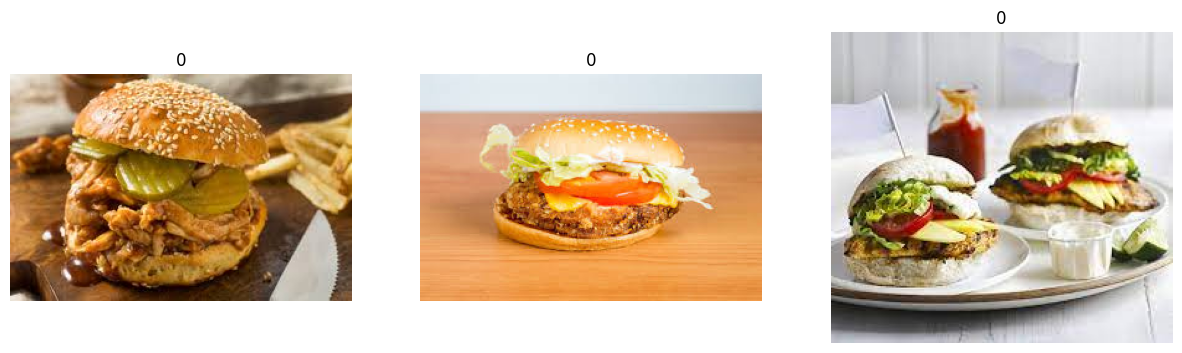

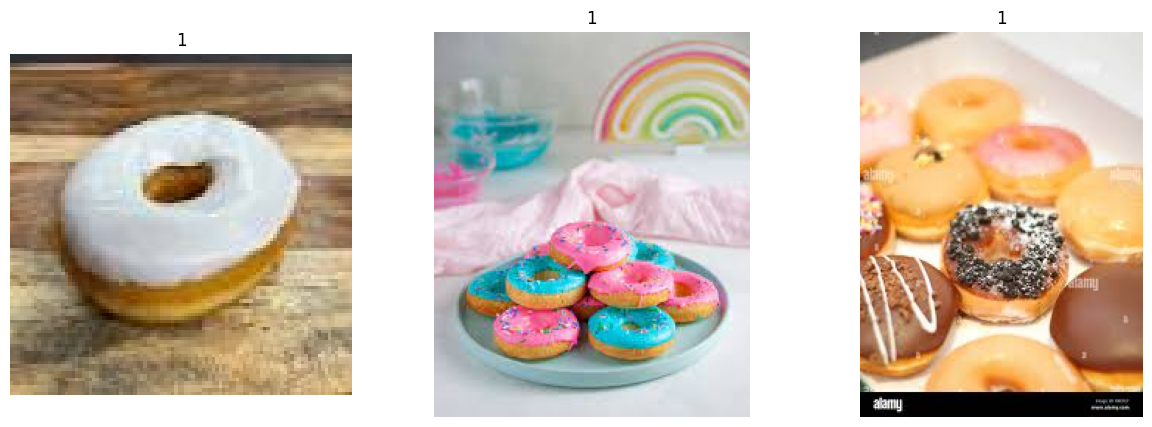

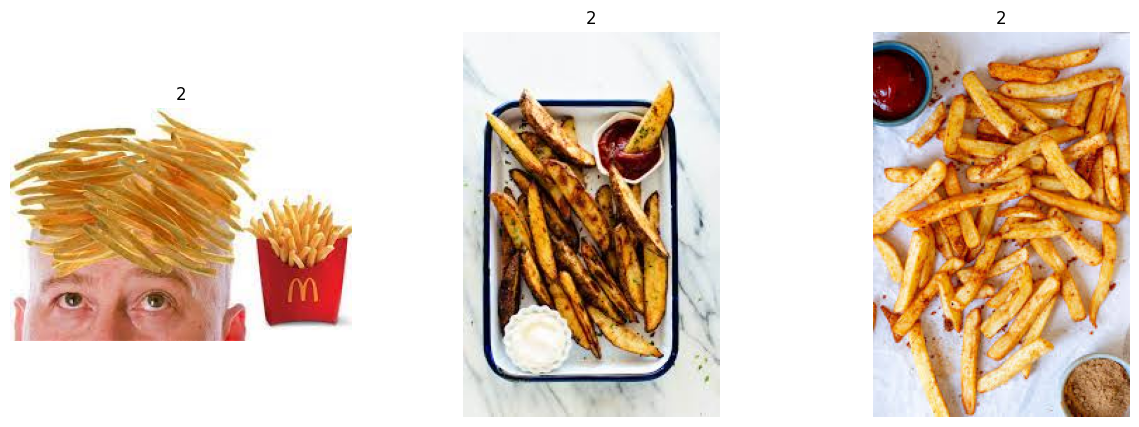

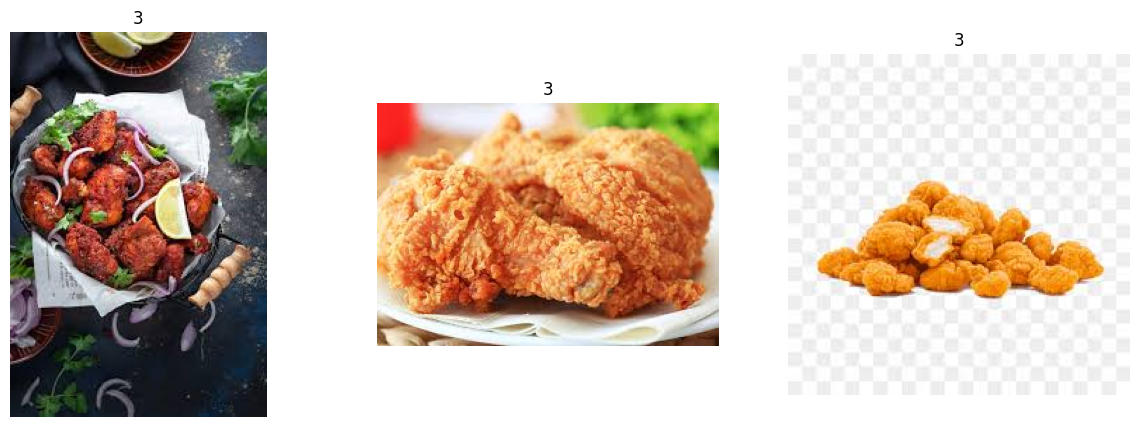

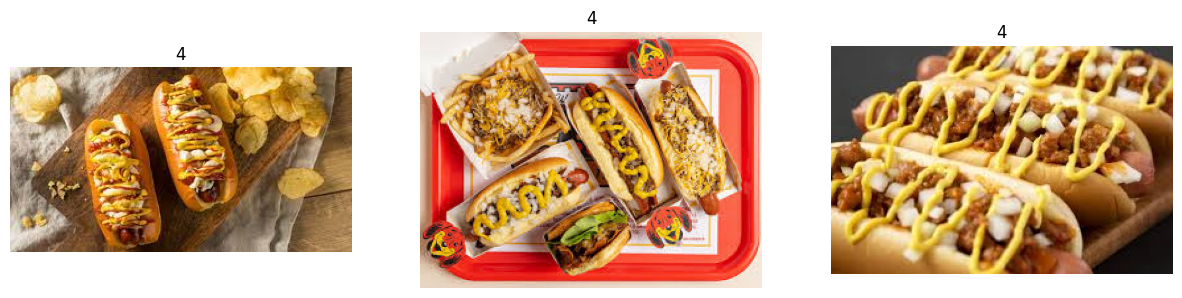

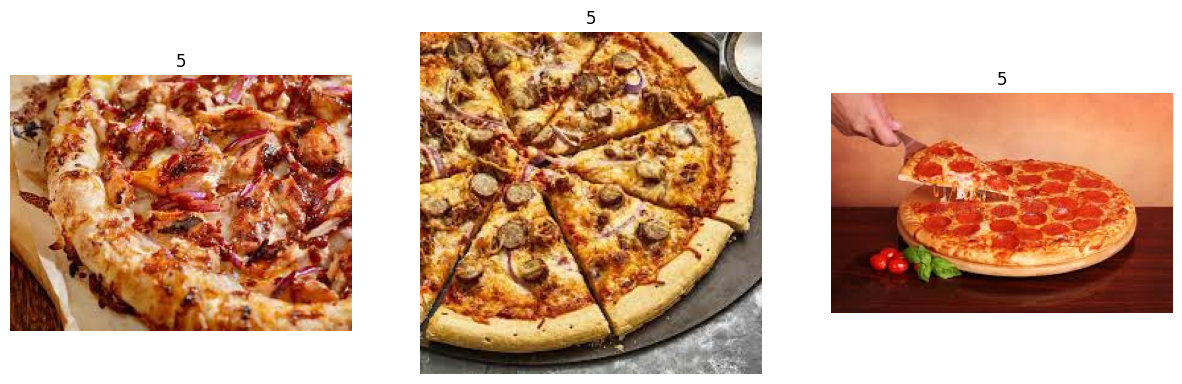

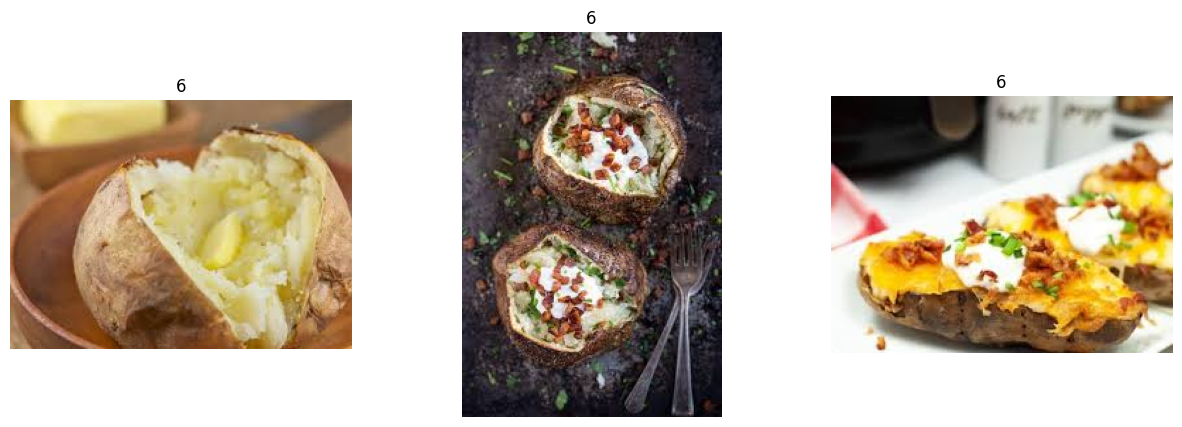

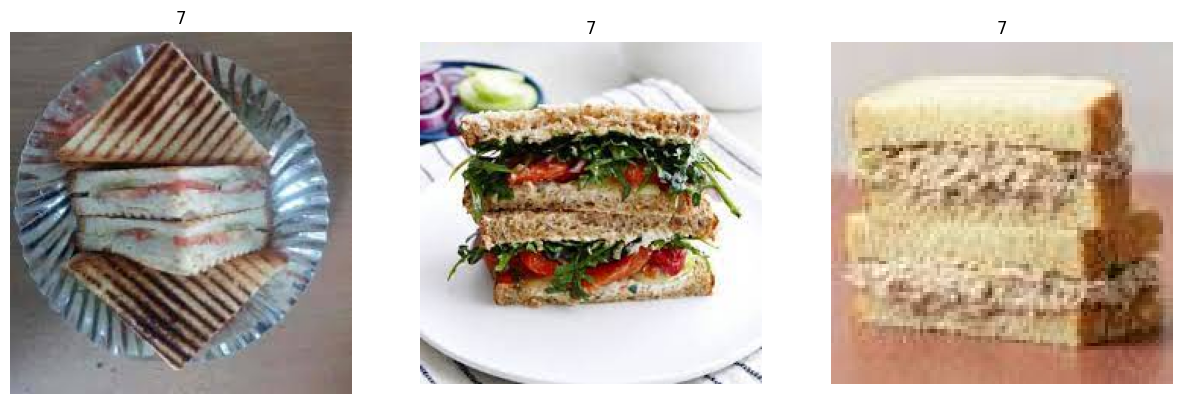

In [22]:
# show 3 images of each prediction
groups_result = result_df.groupby('prediction')
for prediction in range(8):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, (idx, row) in enumerate(groups_result.get_group(prediction).head(3).iterrows()):
        img = cv2.imread(row['path_img'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i].imshow(img)
        ax[i].set_title(row['prediction'])
        ax[i].axis('off')
    plt.show()

In [23]:
translate = {
    0:0,
    1:2,
    2:3,
    3:1,
    4:4,
    5:5,
    6:7,
    7:6
}

In [29]:
len(translate)

7

In [24]:
# translate predictions
result_df['prediction'] = result_df['prediction'].map(translate)

In [25]:
# cast prediction to int
result_df['prediction'] = result_df['prediction'].astype(int)

In [37]:
# count correct predictions and show accuracy
correct = (result_df['prediction'] == df['label']).sum()
print(f'Correct predictions: {correct}')
print(f'Accuracy: {correct/len(result_df):.2%}')

Correct predictions: 4591
Accuracy: 95.65%


In [30]:
# save results to fixed json 'predictions.json'.
# store in json like {idx_test: prediction}
save = result_df.set_index('idx_test')
result = save['prediction'].to_dict()
result = {'target': result}

In [31]:
with open('predictions.json', 'w') as fp:
    json.dump(result, fp)

In [32]:
# load results from fixed json 'predictions.json'.
with open('predictions.json') as f:
    ndata = json.load(f)

In [34]:
len(ndata.get('target'))

4797

---
### Missing images

In [17]:
print(make_prediction_id(missing.iloc[1]['path_img']))

0


![](images/missing/0c1bfb1d-8493-475d-8830-17f124cf69c8.jpeg)

In [18]:
print(make_prediction_id(missing.iloc[2]['path_img']))

2


![](images/missing/866fb6d9-18c7-4f6a-900d-0f51db24fcbd.jpeg)

In [19]:
# make prediction for image
print(make_prediction_id(missing.iloc[0]['path_img']))

4


In [ ]:
# show image
import ipywidgets as widgets
from IPython.display import display, Image, clear_output

# Assuming 'missing' is a pandas DataFrame with a column 'path_img'
filename = missing.iloc[0]['path_img']

# Create checkbox widget
checkbox = widgets.Checkbox(description='Image might be inappropriate. Click to view anyways.')

# Create output widget
output = widgets.Output()

# Define function to display image
def display_image(filename):
    # Display the image
    img = Image(filename=filename)
    with output:
        clear_output()
        display(img)

# Define function to handle checkbox change
def handle_checkbox_change(change):
    if change.new:
        display_image(filename)
    else:
        with output:
            clear_output()
            print("Image hidden.")

# Attach checkbox and output to the notebook
display(checkbox)
display(output)

# Register handle_checkbox_change as a callback for checkbox changes
checkbox.observe(handle_checkbox_change, names='value')


Checkbox(value=False, description='Image might be inappropriate. Click to view anyways.')

Output()